# Lämpötilan vaikutus kohteen lämmitykseen ja jäähdytykseen

## Kirjastot

In [2]:
# https://helsinki-openapi.nuuka.cloud/swagger/index.html
# https://www.ilmatieteenlaitos.fi/havaintojen-lataus
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import urllib.response
from urllib.parse import urlparse
import datetime
import calendar
import matplotlib.dates as mdates
from urllib.parse import unquote
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
import contextily as ctx
import geopandas
import geoplot
import mpld3
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
from mpld3 import plugins
from shapely.geometry import Point, Polygon

pd.set_option('display.max_colwidth', -1) # näytetään sarakeotsikot kokonaan
pd.set_option('display.max_rows', None) # näytetään kaikki rivit

## Jäähdytys ja lämmitys

In [3]:
# AINOASTAAN NÄISTÄ KOHTEISTA SAATAVILLA KAUKOJÄÄHDYTYSTIETOJA
distcool = ['4669 Oodi Helsingin keskustakirjasto','1630 K 4, Elefanttikortteli', '1764 K31, Sarvikuono kortteli', '4382 Töölön kirjasto', '4603 Jätkäsaaren pelastusasema/PO']

# parametrit
kohde = distcool[1]
vuosi = "2020"

# haetaan data
df = pd.read_json("https://helsinki-openapi.nuuka.cloud/api/v2.0/EnergyData/Daily/ListByProperty?Record=LocationName&SearchString=" + kohde.split(" ")[0] + "&ReportingGroup=Heat&StartTime=" + vuosi + "-01-01&EndTime=" + vuosi + "-12-31")
dfcool = pd.read_json("https://helsinki-openapi.nuuka.cloud/api/v2.0/EnergyData/Daily/ListByProperty?Record=LocationName&SearchString=" + kohde.split(" ")[0] + "&ReportingGroup=DistrictCooling&StartTime=" + vuosi + "-01-01&EndTime=" + vuosi + "-12-31")
df['cool'] = dfcool['value']
df.rename(columns={'value':'heat'}, inplace=True)

## Säätiedot

In [4]:
#Haetaan data
dfsaa = pd.read_csv(r'\Users\JereP\Documents\koulu\Helsingin_kiinteistöjen_energia\saa' + vuosi + '.csv', encoding='utf-8')
#kootaan sarakkeista yksi timestamp
dfsaa.rename(columns={'Vuosi':'year', 'Kk':'month', 'Pv':'day'}, inplace=True)
dfsaa['timestamp'] = pd.to_datetime(dfsaa[['year','month','day']])
# poistetaan ruthat sarakkeet, ja täytetään nan kentät
dfsaa.drop(columns=['year', 'month','day', 'Klo', 'Aikavyöhyke'], inplace=True)
dfsaa.ffill(axis = 0, inplace=True)
print('korrelaatio: ')
df['heat'].corr(dfsaa['Ilman lämpötila (degC)'])

korrelaatio: 


-0.9849159365671366

## Koko vuosi

C:\Users\JereP\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


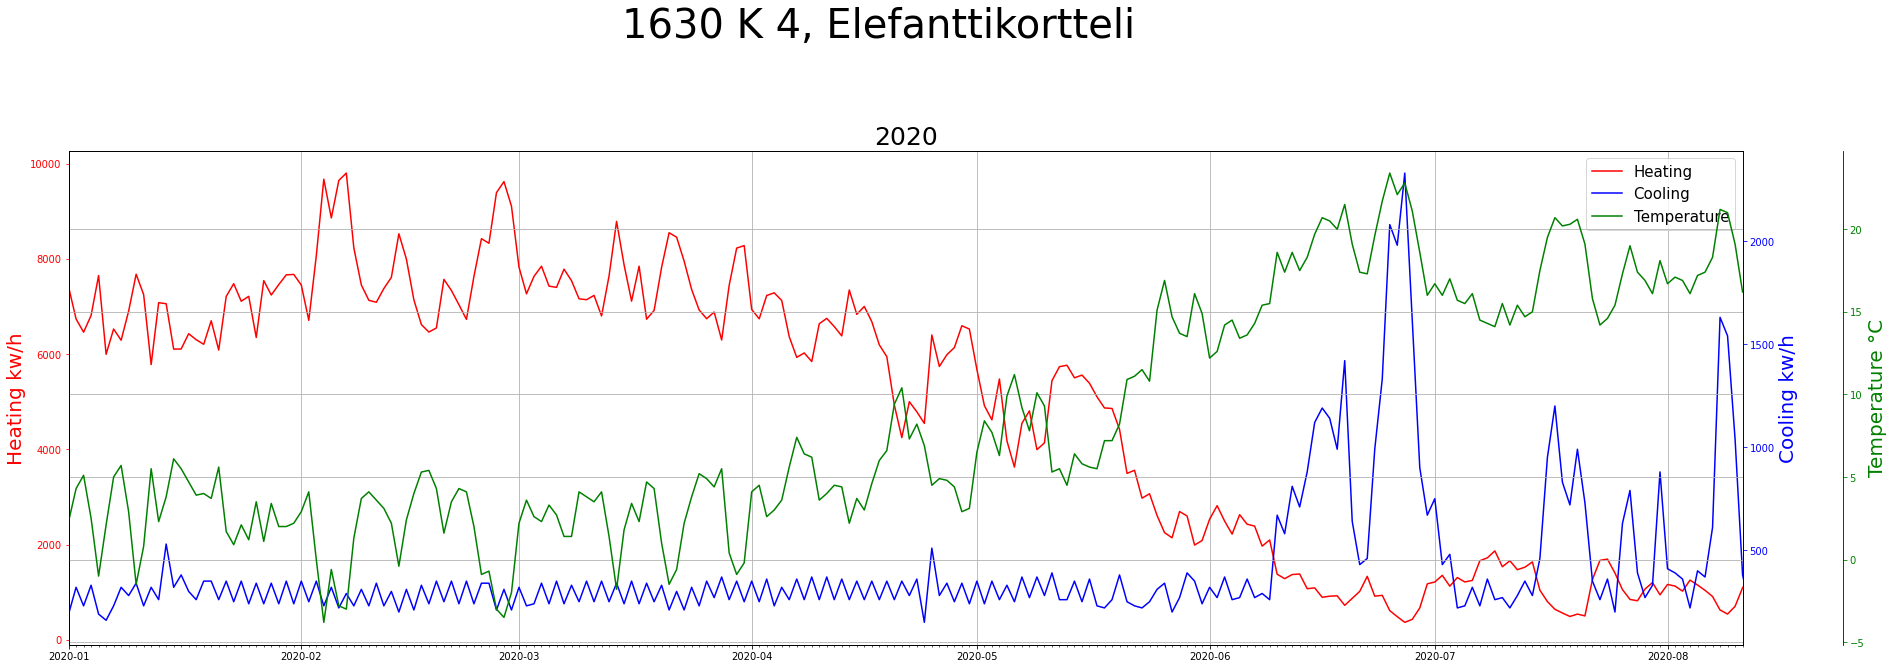

In [5]:
#Luodaan kuvio
fig = plt.figure()
host = fig.add_subplot(211)
fig.set_size_inches(30, 20)

#jaetaan x-akseli
par1 = host.twinx()
par2 = host.twinx()

# nimetään akselit, ja annetaan värit
fig.suptitle(kohde, fontsize=40)
host.set_title(vuosi, fontsize=25)
host.set_ylabel("Heating kw/h", fontsize=20)
par1.set_ylabel("Cooling kw/h", fontsize=20)
par2.set_ylabel("Temperature °C", fontsize=20)
color1 = "red"
color2 = "blue"
color3 = "green"
host.yaxis.label.set_color(color1)
par1.yaxis.label.set_color(color2)
par2.yaxis.label.set_color(color3)

#piirretään viivat
p1, = host.plot(df['timestamp'], df['heat'], color=color1, label="Heating")
p2, = par1.plot(df['timestamp'], df['cool'], color=color2, label="Cooling")
p3, = par2.plot(dfsaa['timestamp'], dfsaa['Ilman lämpötila (degC)'], color=color3, label="Temperature")

par2.grid()
par2.spines['right'].set_position(('outward', 100))
lns = [p1, p2, p3]
host.legend(handles=lns, loc='best', fontsize=15)
host.xaxis.grid()
host.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
host.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
host.xaxis.set_minor_locator(mdates.DayLocator(interval=1))


host.tick_params(axis='y', colors=color1)
par1.tick_params(axis='y', colors=color2)
par2.tick_params(axis='y', colors=color3)

host.set_xlim(vuosi + "-01-01", vuosi + "-08-11")
plt.show()

## Kesä-Heinä 2018

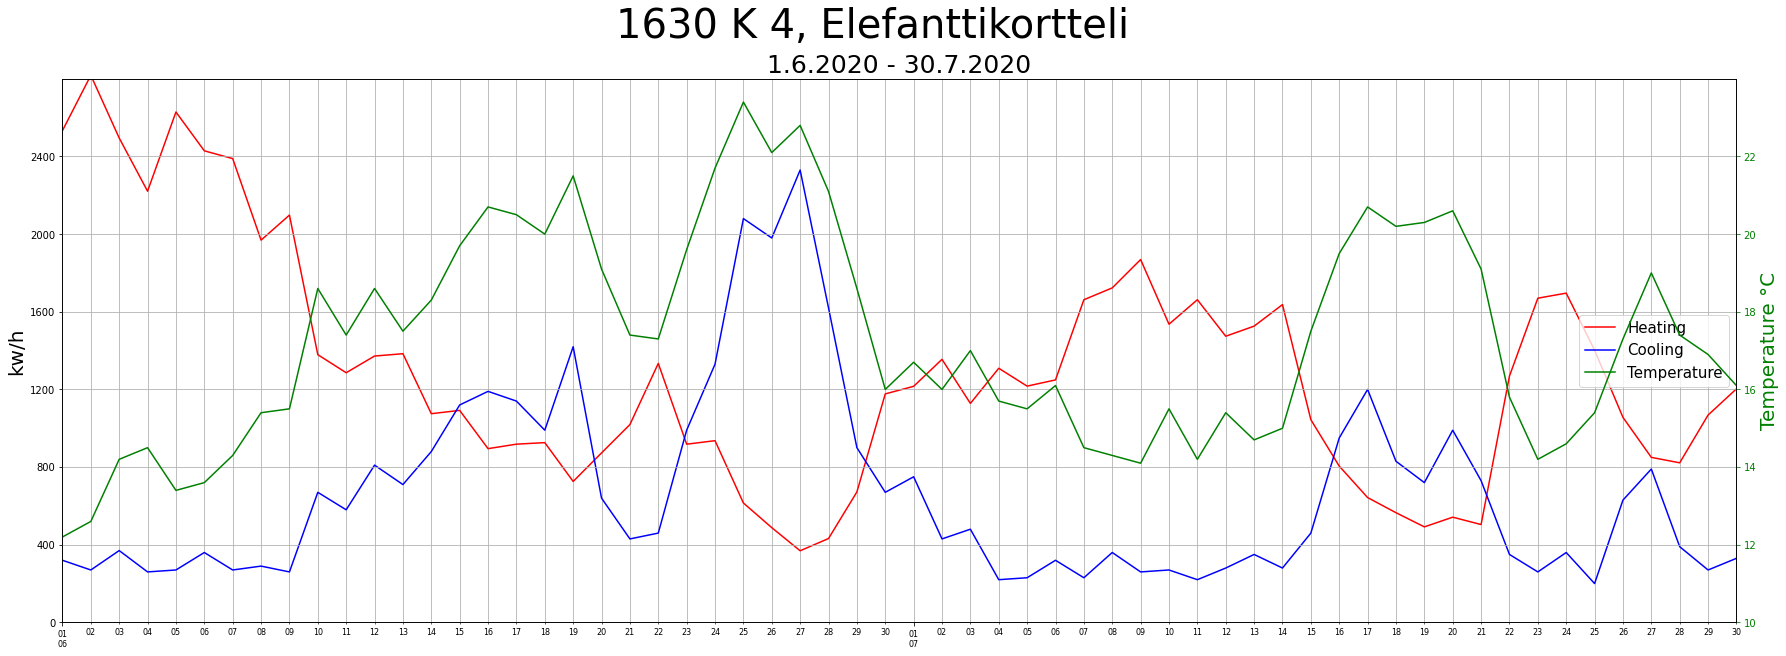

In [6]:
#Luodaan kuvio
fig = plt.figure()
host = fig.add_subplot(111)
fig.set_size_inches(30, 10)

#jaetaan x-akseli
par2 = host.twinx()

color1 = "red"
color2 = "blue"
color3 = "green"

#piirretään viivat
p1, = host.plot(df['timestamp'], df['heat'], color=color1, label="Heating")
p2, = host.plot(df['timestamp'], df['cool'], color=color2, label="Cooling")
p3, = par2.plot(dfsaa['timestamp'], dfsaa['Ilman lämpötila (degC)'], color=color3, label="Temperature")
lns = [p1, p2, p3]
host.legend(handles=lns, loc='center right', fontsize=15)
fig.suptitle(kohde, fontsize=40)
host.set_title("1.6.2020 - 30.7.2020", fontsize=25)
host.set_ylabel("kw/h", fontsize=20)
                
par2.set_ylabel("Temperature °C", fontsize=20)
par2.grid()
par2.spines['right']
par2.yaxis.label.set_color(p3.get_color())
                
host.xaxis.grid()
host.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
host.xaxis.set_minor_formatter(mdates.DateFormatter('%d'))
host.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
host.xaxis.set_major_formatter(mdates.DateFormatter('%d\n%m'))
host.xaxis.grid(which='minor')

host.tick_params(axis='x', which='both', labelsize=8)
par2.tick_params(axis='y', colors=color3)
par2.set_yticks(np.arange(0,24,2))
par2.set_ylim(10,24)
host.set_ylim(0,2800)
host.set_yticks(np.arange(0,2600,400))
host.set_xlim(vuosi + "-06-01", vuosi + "-07-30")
plt.show()

## 15.6-30.6 (suurin muutos lämpötilassa)

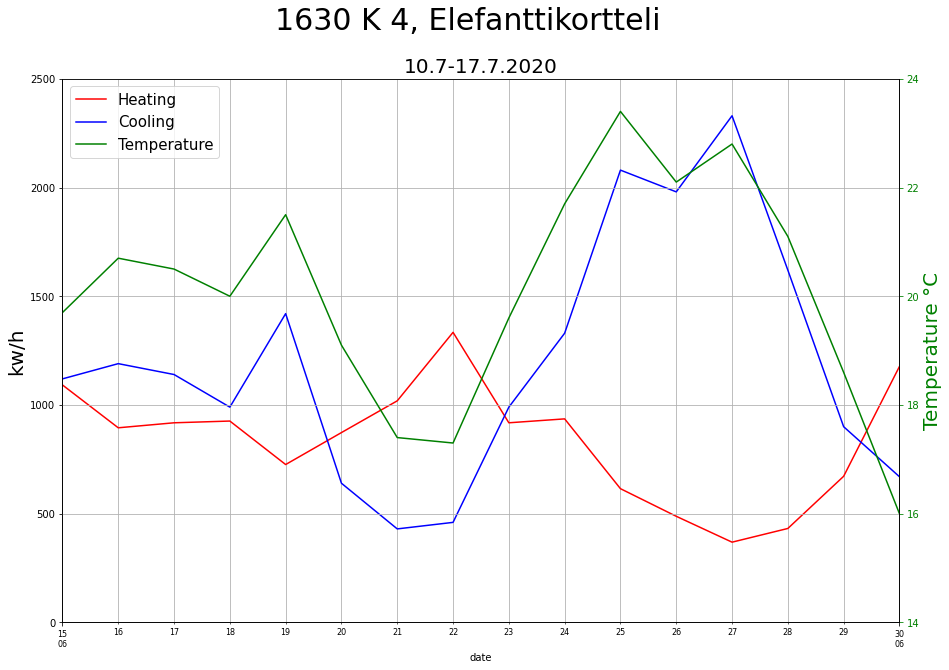

In [11]:
#luodaan kuvio
fig = plt.figure()
host = fig.add_subplot(111)
fig.set_size_inches(15, 10)

#jaetaan x akseli
par2 = host.twinx()

color1 = "red"
color2 = "blue"
color3 = "green"

#piirretään viivat
p1, = host.plot(df['timestamp'], df['heat'], color=color1, label="Heating")
p2, = host.plot(df['timestamp'], df['cool'], color=color2, label="Cooling")
p3, = par2.plot(dfsaa['timestamp'], dfsaa['Ilman lämpötila (degC)'], color=color3, label="Temperature")

lns = [p1, p2, p3]
host.legend(handles=lns, loc='best', fontsize=15)
fig.suptitle(kohde, fontsize=30)
host.set_title("10.7-17.7.2020", fontsize=20)
host.set_ylabel("kw/h", fontsize=20)
par2.set_ylabel("Temperature °C", fontsize=20)

par2.spines['right']
host.xaxis.grid()
par2.yaxis.grid()
par2.yaxis.label.set_color(p3.get_color())

host.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
host.xaxis.set_minor_formatter(mdates.DateFormatter('%d'))
host.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
host.xaxis.set_major_formatter(mdates.DateFormatter('%d\n%m'))
host.xaxis.grid(which='minor')

host.tick_params(axis='x', which='both', labelsize=8)
par2.tick_params(axis='y', colors=color3)

par2.set_ylim(14,24)
host.set_ylim(0,2500)
host.set_xlim(vuosi + "-06-15", vuosi + "-06-30")
host.set_xlabel('date')
plt.show()

## 25.6 tunneittain

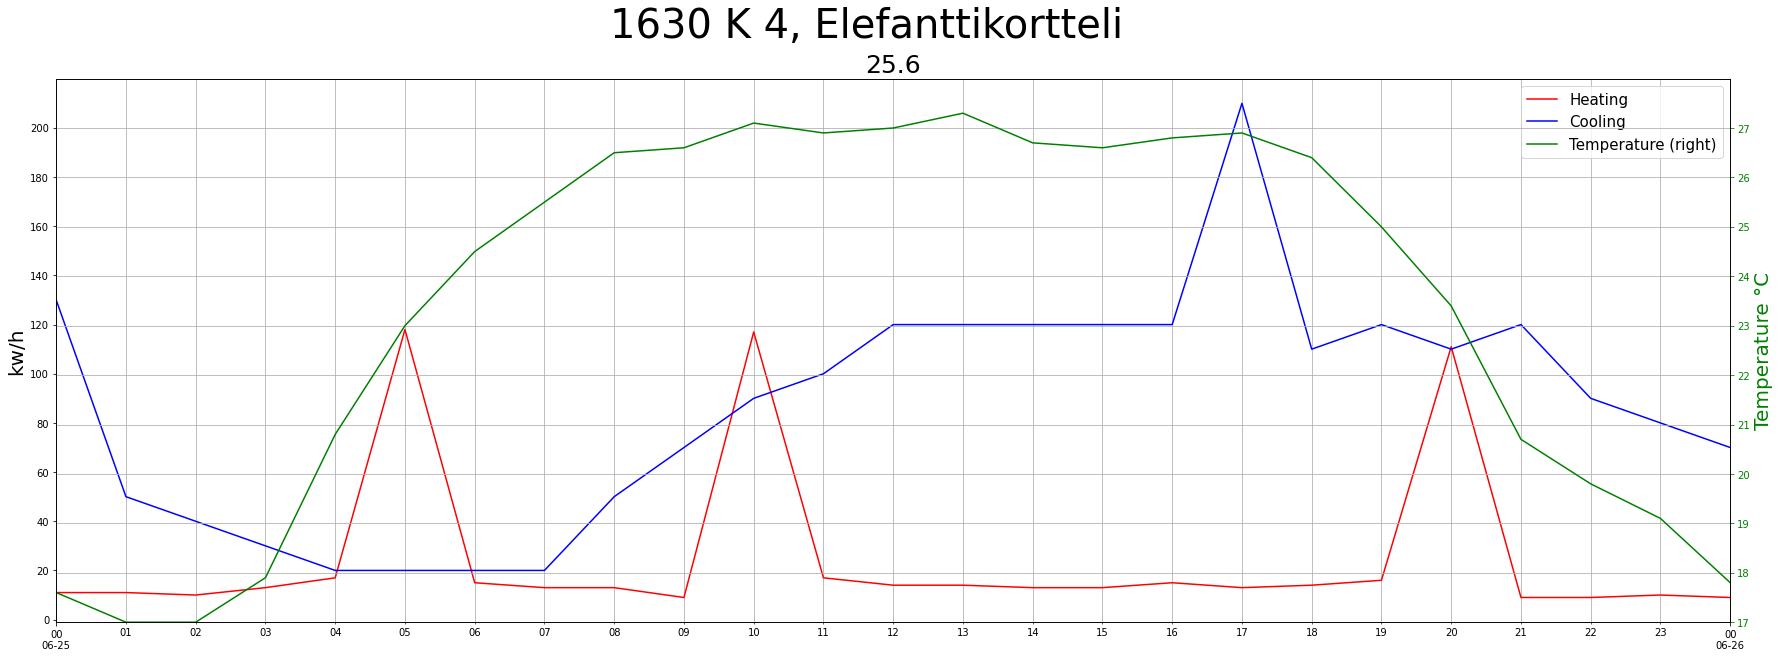

In [8]:

start2 = vuosi + "-06-25"
end2 = vuosi + "-06-26"

# kulutustiedot
df3 = pd.read_json("https://helsinki-openapi.nuuka.cloud/api/v2.0/EnergyData/Hourly/ListByProperty?Record=LocationName&SearchString=" + kohde.split(" ")[0] + "&ReportingGroup=Heat&StartTime=" + start2 + "&EndTime=" + end2)
dfcool2 = pd.read_json("https://helsinki-openapi.nuuka.cloud/api/v2.0/EnergyData/Hourly/ListByProperty?Record=LocationName&SearchString=" + kohde.split(" ")[0] + "&ReportingGroup=DistrictCooling&StartTime=" + start2 + "&EndTime=" + end2)
df3['cool'] = dfcool2['value']
df3.rename(columns={'value':'heat'}, inplace=True)

#säätiedot
dfsaa3 = pd.read_csv(r'\Users\JereP\Documents\koulu\Helsingin_kiinteistöjen_energia\saa' + vuosi + 'heina.csv', encoding='utf-8')
dfsaa3.rename(columns={'Vuosi':'year', 'Kk':'month', 'Pv':'day'}, inplace=True)
dfsaa3['timestamp'] = pd.to_datetime(dfsaa3[['year','month','day']])
dfsaa3.drop(columns=['year', 'month','day', 'Klo', 'Aikavyöhyke'], inplace=True)
dfsaa3.ffill(axis = 0, inplace=True)
tunnit = np.arange(0,24).tolist()
valmis = []
for x in range(31):
    valmis.extend(tunnit)
valmis.append(0)
dfsaa3['hour'] = pd.Series(valmis)
dfsaa3['timestamp'] +=  pd.to_timedelta(dfsaa3['hour'], unit='h')

# Luodaan kuvio
fig = plt.figure()
host = fig.add_subplot(111)
fig.set_size_inches(30, 10)
par2 = host.twinx()

color1 = "red"
color2 = "blue"
color3 = "green"

#Piirretään kaavat
p1, = host.plot(df3['timestamp'], df3['heat'], color=color1, label="Heating")
p2, = host.plot(df3['timestamp'], df3['cool'], color=color2, label="Cooling")
p3, = par2.plot(dfsaa3['timestamp'], dfsaa3['Ilman lämpötila (degC)'], color=color3, label="Temperature (right)")


lns = [p1, p2, p3]
host.legend(handles=lns, loc='best', fontsize=15)
fig.suptitle(kohde, fontsize=40)
host.set_title("25.6", fontsize=25)
host.set_ylabel("kw/h", fontsize=20)
par2.set_ylabel("Temperature °C", fontsize=20)

par2.spines['right']
par2.grid()


host.xaxis.set_minor_locator(mdates.HourLocator(interval=1))
host.xaxis.set_minor_formatter(mdates.DateFormatter('%H'))
host.xaxis.set_major_locator(mdates.DayLocator(interval=1))
host.xaxis.set_major_formatter(mdates.DateFormatter('%H\n%m-%d'))
host.xaxis.grid(which='minor')


par2.yaxis.label.set_color(p3.get_color())
par2.tick_params(axis='y', colors=color3)
par2.set_ylim(17,28)
par2.set_yticks(np.arange(17,28,1))
host.set_xlim(start2, end2)
host.set_yticks(np.arange(0,220,20))
plt.show()